<h1><center>Titanic: machine learning insights from disaster</center></h1>

### This notebook is based on the awesome course series brought by [Dan](https://www.kaggle.com/dansbecker), some of the code and explanations were taken from there, if you like what you see here I highly recommend to checkout these links:
* [Permutation Importance](https://www.kaggle.com/dansbecker/permutation-importance)
* [Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
* [SHAP Values](https://www.kaggle.com/dansbecker/shap-values)
* [Advanced Uses of SHAP Values](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values?utm_medium=email&utm_source=mailchimp&utm_campaign=ml4insights)

### Here I'll try to put in practice some of what I learned from the course in another data set, and hopefully get more people attention to these very useful techniques of how to get more from your machine learning models.

### Machine learning insights are meant to give you more information about how and what your model is doing, this way you have a better interpretability of what's is going on, explain the model and it's predictions to other people, validate and improve it.

#### What we'll do:
* Load data and do some basic data engineering.
* Use [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html) to model our data.
* Take insights from our model.
    * Permutation importance.
    * Partial plots.
    * SHAP values.
    * Advanced use of SHAP values.

### Dependencies

In [1]:
import re
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp
import shap

shap.initjs()

### Load data

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

### Feature engineering

In [3]:
def pre_process_data(df):
    # Add "title" feature
    df['title'] = df.apply(lambda row: re.split('[,.]+', row['Name'])[1], axis=1)
    
    # Add "family" feature
    df['family'] = df['SibSp'] + df['Parch'] + 1
    
    # One-hot encode categorical values.
    df = pd.get_dummies(df, columns=['Sex', 'Embarked', 'title'])
    
    # Drop columns unwanted columns
    # I'm dropping "Cabin" because it has too much missing data.
    df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

    return df


# Get labels
# labels = train['Survived'].values
labels = train['Survived']
train.drop(['Survived'], axis=1, inplace=True)
# Get test ids
test_ids = test['PassengerId'].values

train = pre_process_data(train)
test = pre_process_data(test)

# align both data sets (by outer join), to make they have the same amount of features,
# this is required because of the mismatched categorical values in train and test sets.
train, test = train.align(test, join='outer', axis=1)

# replace the nan values added by align for 0
train.replace(to_replace=np.nan, value=0, inplace=True)
test.replace(to_replace=np.nan, value=0, inplace=True)

### In case you wanna take a look at the data

In [4]:
train.head()

,Age,Embarked_C,Embarked_Q,Embarked_S,Fare,Parch,Pclass,Sex_female,Sex_male,SibSp,family,title_ Capt,title_ Col,title_ Don,title_ Dona,title_ Dr,title_ Jonkheer,title_ Lady,title_ Major,title_ Master,title_ Miss,title_ Mlle,title_ Mme,title_ Mr,title_ Mrs,title_ Ms,title_ Rev,title_ Sir,title_ the Countess
0,22.0,0,0,1,7.2500,0,3,0,1,1,2,0,0,0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,38.0,1,0,0,71.2833,0,1,1,0,1,2,0,0,0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,26.0,0,0,1,7.9250,0,3,1,0,0,1,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,35.0,0,0,1,53.1000,0,1,1,0,1,2,0,0,0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,35.0,0,0,1,8.0500,0,3,0,1,0,1,0,0,0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [5]:
train.describe()

,Age,Embarked_C,Embarked_Q,Embarked_S,Fare,Parch,Pclass,Sex_female,Sex_male,SibSp,family,title_ Capt,title_ Col,title_ Don,title_ Dona,title_ Dr,title_ Jonkheer,title_ Lady,title_ Major,title_ Master,title_ Miss,title_ Mlle,title_ Mme,title_ Mr,title_ Mrs,title_ Ms,title_ Rev,title_ Sir,title_ the Countess
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.0,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,23.799293,0.188552,0.086420,0.722783,32.204208,0.381594,2.308642,0.352413,0.647587,0.523008,1.904602,0.001122,0.002245,0.001122,0.0,0.007856,0.001122,0.001122,0.002245,0.044893,0.204265,0.002245,0.001122,0.580247,0.140292,0.001122,0.006734,0.001122,0.001122
std,17.596074,0.391372,0.281141,0.447876,49.693429,0.806057,0.836071,0.477990,0.477990,1.102743,1.613459,0.033501,0.047351,0.033501,0.0,0.088337,0.033501,0.033501,0.047351,0.207186,0.403390,0.047351,0.033501,0.493796,0.347485,0.033501,0.081830,0.033501,0.033501
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,0.000000,0.000000,7.910400,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24.000000,0.000000,0.000000,1.000000,14.454200,0.000000,3.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,35.000000,0.000000,0.000000,1.000000,31.000000,0.000000,3.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,80.000000,1.000000,1.000000,1.000000,512.329200,6.000000,3.000000,1.000000,1.000000,8.000000,11.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Split data

In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(train, labels, test_size=0.2, random_state=1)

### Model
* Model really isn't the focus here so I won't try to build something super good, but I think it's good to leave a clear and organized code anyway.

#### Train

In [7]:
model = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree=0.3, learning_rate=0.1,max_depth=8, n_estimators=50)
model.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

#### Validation

In [8]:
predictions = model.predict(X_val)
# Basic metrics from the model
accuracy = accuracy_score(predictions, Y_val)
recall = recall_score(predictions, Y_val)
precision = precision_score(predictions, Y_val)

print('Model metrics')
print('Accuracy: %.2f' % accuracy)
print('Recall: %.2f' % recall)
print('Precision: %.2f' % precision)

Model metrics
Accuracy: 0.79
Recall: 0.85
Precision: 0.60


### Now we can finally take some insights from our model.

#### Let's begin with permutation importance, XGBoost already give us a nice way to visualize feature importance base on F score, let's take a look.

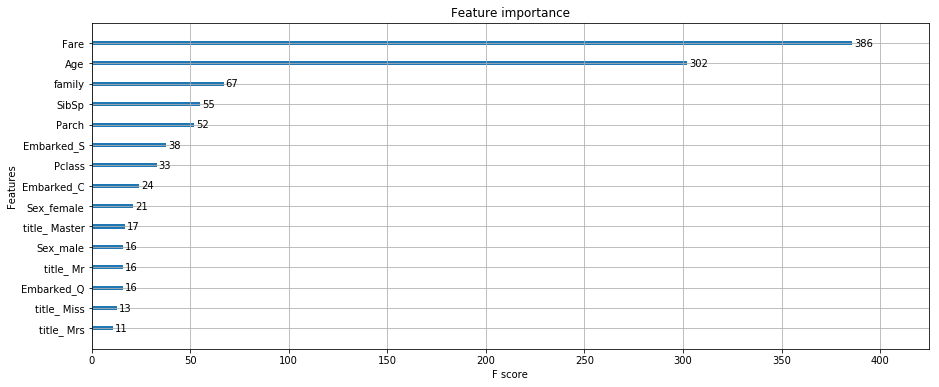

In [9]:
plt.rcParams["figure.figsize"] = (15, 6)
xgb.plot_importance(model)
plt.show()

Based on this graph we can see that age and fare values were the most important features (older and people who paid more had a higher chance to survive), also females had more chance than males to survive.

### Now we can try permutation importance.
* Permutation importance is a cool technique that give us another angle evaluation feature importance.
* It's calculated after a model has been fitted.
* Basically we ask the following question: If I randomly shuffle a single column of the validation data, leaving the target and all other columns in place, how would that affect the accuracy of predictions in that now-shuffled data?
* This way if a feature has high importance shuffling it should lower our model metrics, on the other hand if shuffling don't impact the metrics too much that feature has low importance (it doesn't really matter to the model).


###### Important note here for anyone trying to use eli5's PermutationImportance on XGBoost estimators, currently you need to train your models using ".as_matrix()" with you input data (X and Y), otherwise PermutationImportance won't work.

In [10]:
# Fitting the model again so it can work with PermutationImportance.
model_PI = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree=0.3, learning_rate=0.1,max_depth=8, n_estimators=50)
model_PI.fit(X_train.values, Y_train.values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [11]:
perm = PermutationImportance(model_PI, random_state=1).fit(X_train, Y_train)
eli5.show_weights(perm, feature_names=X_val.columns.tolist())

Weight,Feature
0.0489 ± 0.0054,Fare
0.0368 ± 0.0065,Pclass
0.0284 ± 0.0184,Sex_male
0.0233 ± 0.0072,Age
0.0225 ± 0.0131,Sex_female
0.0087 ± 0.0028,title_ Master
0.0079 ± 0.0068,family
0.0065 ± 0.0063,Embarked_S
0.0039 ± 0.0021,SibSp
0.0034 ± 0.0029,Parch


So, the values can go from green to red, being the greener the more important the feature is (top features) and the whiter, less important the feature is (bottom features).

The first number in each row shows how much model performance  (in this case, using "accuracy" as the performance metric) decreased with a random shuffling with a confidence interval (variance from the multiple shuffles).

Negative values (red) means that the shuffling actually improved the model performance, so those features don't really matter but the shuffling (fake data) improved them.

In this case the top 2 features (the 2 most important) were the same that we got from XGBoost feature importance method, but here "Pclass" seems to be as important as "Age", another interesting thing here is that "Sex_female" and "Sex_female" have the same importance, this may seem strange at first but remember that they are true/false features, and the opposite of the other, so actually this make all sense.

### Next let's do some partial plots.
* The aim of partial plots is to show how a feature affects predictions.
* It's calculated after a model has been fitted.
* To calculate the data for our plot, we could take one row of data make a prediction on that row, and repeatedly alter the value for one variable to make a series of predictions. Then we trace out predicted outcomes (on the vertical axis). To have a more robust representation, we make this process to multiple rows of data, and plot the average predicted outcome.

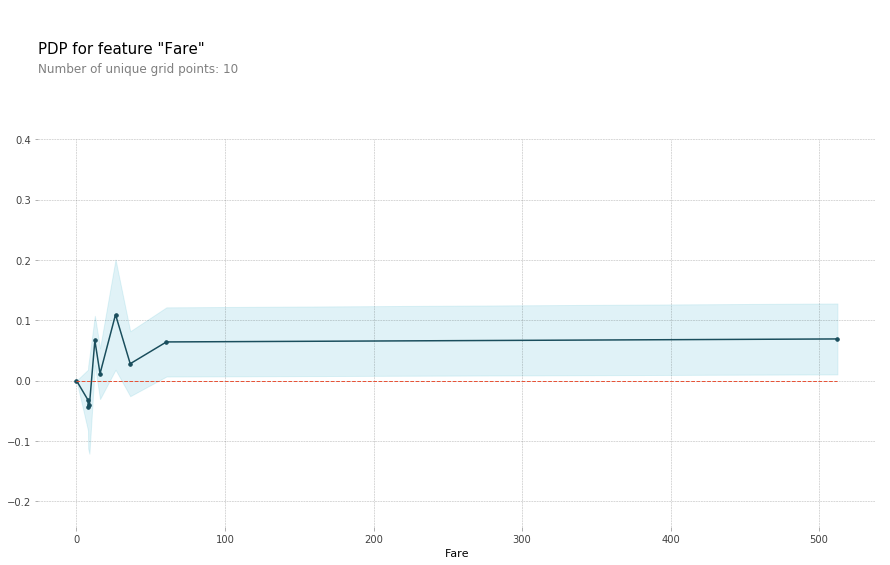

In [12]:
feature_names = train.columns.tolist()
pdp_fare = pdp.pdp_isolate(model=model, dataset=X_val, model_features=feature_names, feature='Fare')
pdp.pdp_plot(pdp_fare, 'Fare')
plt.show()

About the plot
* The y axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value.
* A blue shaded area indicates level of confidence

Here we have a strange behavior, on the first few points, this may be because of the small dataset and some noisy data, but if we smooth that line, we can see that the higher the fare is more it contributes to higher predictions, this is true to around fare = 60, from this point it seems that increasing fare has no impact in predictions. Anyway the impact seems to be small.

### Let's try on "Pclass"

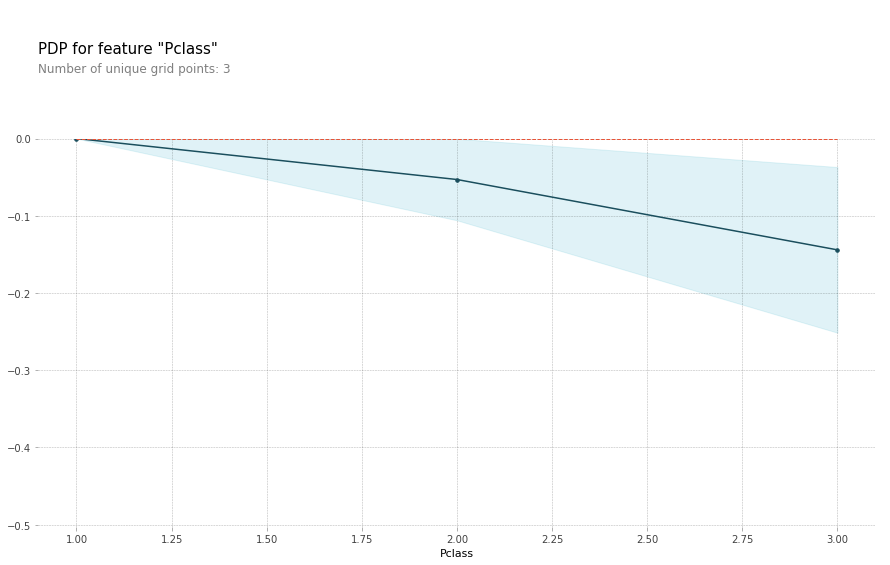

In [13]:
pdp_fare = pdp.pdp_isolate(model=model, dataset=X_val, model_features=feature_names, feature='Pclass')
pdp.pdp_plot(pdp_fare, 'Pclass')
plt.show()

Here we have a more clear plot of how this feature affects predictions, as we increase the "Pclass" we have a lower predicted value, this make all sense because higher classes had people with more money, and probably had priority leaving the ship, compared to people from lower classes.

### 2D Partial Dependence Plots
* We can also use partial plots to evaluate interactions between features and the label, with 2D dependence plots.

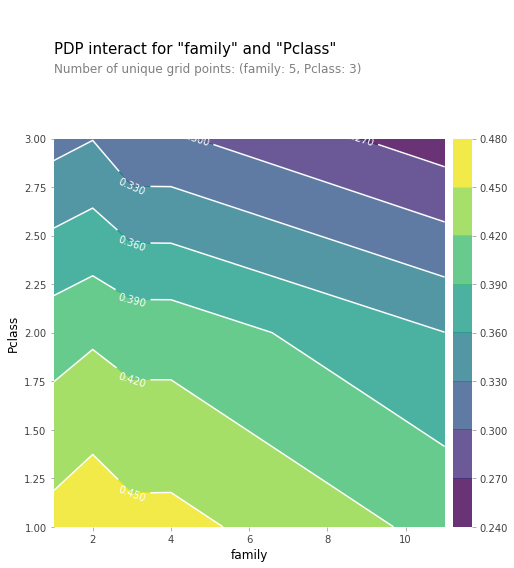

In [14]:
features_to_plot1 = ['family', 'Pclass']
pdp_inter = pdp.pdp_interact(model=model, dataset=X_val, model_features=feature_names, features=features_to_plot1)
pdp.pdp_interact_plot(pdp_interact_out=pdp_inter, feature_names=features_to_plot1, plot_type='contour')
plt.show()

Here we have a couple of plots of the interaction between some of our features, on the side of each plot we have a scale of feature importance.

On the first one we have how "Pclas" and "family" interact together on the prediction, as we can see people with smaller families (max of 5 people) and from higher class (1st class) had higher chance to survive, and the people who had more than 9 family member and were from 3rd class had the lower chance.

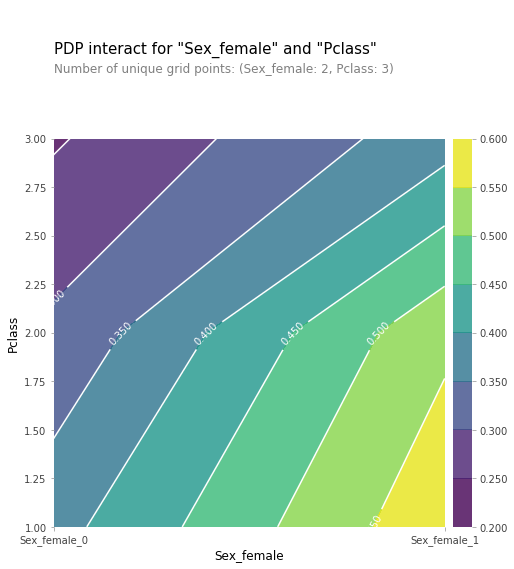

In [15]:
features_to_plot2 = ['Sex_female', 'Pclass']
pdp_inter = pdp.pdp_interact(model=model, dataset=X_val, model_features=feature_names, features=features_to_plot2)
pdp.pdp_interact_plot(pdp_interact_out=pdp_inter, feature_names=features_to_plot2, plot_type='contour')
plt.show()

The second plot show the interaction from "Pclass" and "Sex_female", this on is pretty clear as well, we can see that the people with the higher chance to survive were female (Sex_female = 1) and from the 1st class (Pclass = 1), and the ones with the lowest chances were the opposite, males from the 3rd class.

This kind of plot give us a good understanding of what our model learned, and how features behaves according to it, one good idea would be to validate this insights with the domain expert and see if everything is going as expected.

### SHAP values
* SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature.
* It can be used to help explain how the model got to one prediction, e.g. a model says a bank shouldn't loan someone money, and the bank is legally required to explain the basis for each loan rejection.
* SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value.

In [16]:
row_to_show = 14
data_for_prediction = X_val.iloc[[row_to_show]]
explainer = shap.TreeExplainer(model)
shap_values_single = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values_single, data_for_prediction)

Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature's effect. Feature values decreasing the prediction are in blue. The features that more increase prediction values were "Sex_female" and "Sex_male" (the person here was a female) here seems clear that having both "Sex_female" and "Sex_male" is redundant, as they mean the same. And the feature that decreased more the prediction was "Pclass" that in this case was 3.

If you subtract the length of the blue bars from the length of the pink bars, it equals the distance from the base value to the output.

### Advanced Uses of SHAP Values

### SHAP summary plots
* These plots will give us a more detailed view of feature importance and what is driving it.

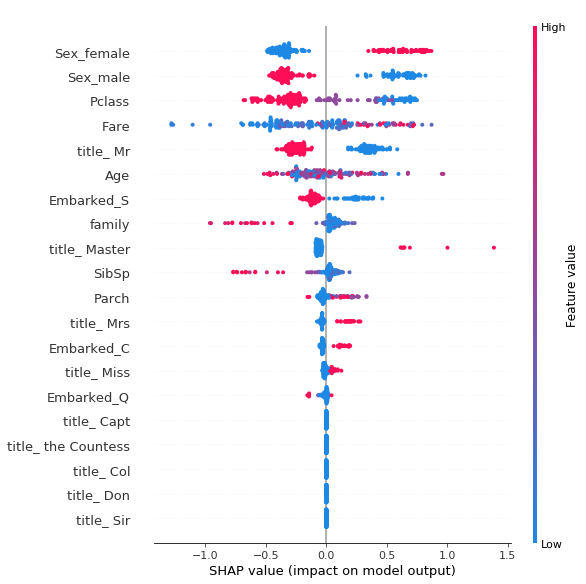

In [17]:
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val)

* Vertical location shows what feature it is depicting
* Color shows whether that feature was high or low for that row of the dataset
* Horizontal location shows whether the effect of that value caused a higher or lower prediction.

For example, pink dots in the "Fare" row, meas high fare values, blue values in the "Sex_female" row means low values, in this case 0 that means that point is a male. Those pink values in "title_Master" row means that the few people that had the title Master had increased chance to survive.

Some insights we can get from this plot:
* The model ignored the bottom 5 features.
* Binary features only have 2 possible colors.
* High values of "Pclass" caused lower predictions, and high values caused higher predictions.

### SHAP Dependence Contribution Plots
* This one reminds the partial dependence plots that we did before, but with a lot more detail.

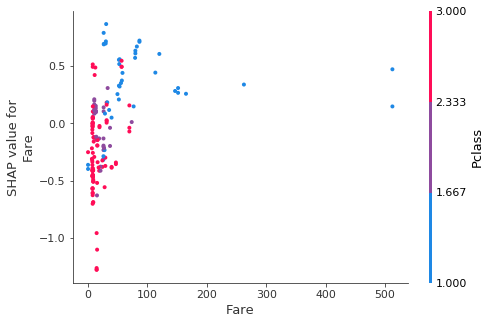

In [18]:
shap.dependence_plot('Fare', shap_values, X_val, interaction_index="Pclass")

* Each dot represents a row of the data.
* The horizontal location is the actual value from the dataset.
* The vertical location shows what having that value did to the prediction.
* Color show the values of another feature, to help we see how they interact.

Here we can see how "Pclass" and "Fare" interact together affecting the predictions, it's clear that higher fares means lower class (1st class), and in general people who paid more had more chance to survive.

Let's try another one.

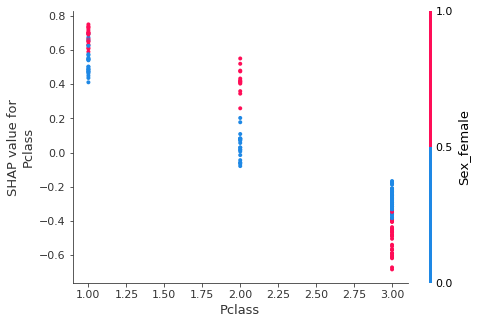

In [19]:
shap.dependence_plot('Pclass', shap_values, X_val, interaction_index="Sex_female")

Here we have something interesting, again people from higher classes had more chance to survive, but for people from the 3rd class females seems to had less chance to survive, what may be the cause?

#### And finally because this is a kernel from a competition, let's make our predictions and output results.

In [20]:
test_predictions = model.predict(test)
submission = pd.DataFrame({"PassengerId":test_ids})
submission["Survived"] = test_predictions
submission.to_csv("submission.csv", index=False)